In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importing libraries
import pandas as pd
import os

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from venny4py.venny4py import *
from pandas.plotting import parallel_coordinates

from src.models import parameter_learning as lfi
from src.models import build_model as build
from src.models import model_schemata as schema
from src.models import inference as inf
from src.visualization import visualize as viz

In [3]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

In [4]:
log_directory = 'models/ebdt_data/p_model/'
mle_analysis, weights = lfi.analyze_and_store_logs(log_directory)
mle_analysis.keys()

dict_keys(['run4-20i', 'run2-20i', 'run3-20i', 'run1-20i'])

In [5]:
mle_scores = {}
keys = list(mle_analysis.keys())
keys.sort()
for key in keys:
    mle_scores[key] = mle_analysis[key]['MLE scores']

#### Evaluation of learning process

Compare score after N iterations

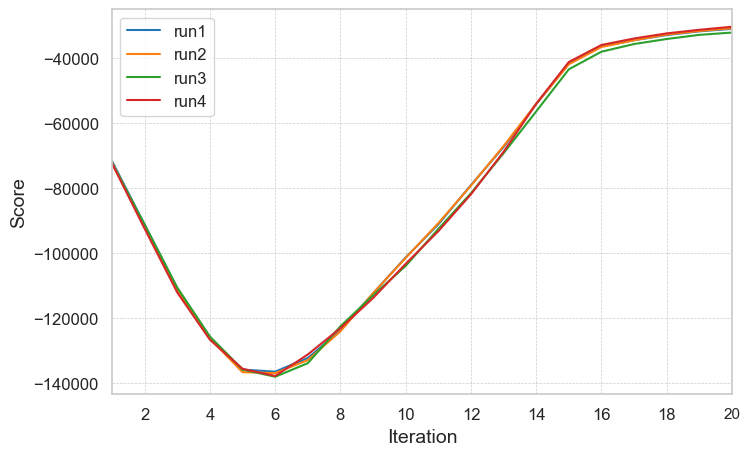

In [7]:
def plot_iteration_scores_seaborn(dataframes, xlim=None, ylim=None):

    sns.set(style="whitegrid")  # Start with a white grid style

    # Save the current Seaborn settings
    current_context = sns.plotting_context()
    current_style = sns.axes_style()

    # Reset to Matplotlib defaults
    plt.rcdefaults()

    # Reapply the saved Seaborn settings except for the color palette
    sns.set_context(current_context)
    sns.set_style(current_style)

    plt.figure(figsize=(8, 5), dpi=100)

    for exp, df in dataframes.items():
        if 'Iteration' not in df.columns or 'Score' not in df.columns:
            print("Each DataFrame must contain 'Iteration' and 'Score' columns.")
            return
        
        # Select rows where iterations and scores are within the specified limits
        if xlim is not None:
            df = df[(df['Iteration'] >= xlim[0]) & (df['Iteration'] <= xlim[1])]
        if ylim is not None:
            df = df[(df['Score'] >= ylim[0]) & (df['Score'] <= ylim[1])]

        sns.lineplot(x='Iteration', y='Score', data=df, label=exp.replace('-20i', ''), linewidth=1.5)

    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Score', fontsize=14)

    # Improve the grid, make it lighter
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Set axis limits if provided
    if xlim is not None:
        plt.xlim(xlim)  # Set x-axis to start from 2
    if ylim is not None:
        plt.ylim(ylim)

    # Increase the legibility of the ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Set x-axis to display only integer ticks
    plt.xticks(range(2, 21, 2))

    plt.legend(title=None, fontsize='12')

    plt.show()

# Usage example
plot_iteration_scores_seaborn(mle_scores, xlim=(1, 20))

Compare time per iteration

In [8]:
times_per_it = {}
compile_time = {}
for key in keys:
    times_per_it[key] = mle_analysis[key]['Time per iteration'] / 3600
    compile_time[key] = mle_analysis[key]['Compile Time'] / 3600

# Convert your data to a suitable format for Seaborn
data = []
for key, time, compile_t in zip(keys, times_per_it.values(), compile_time.values()):
    data.append({'run': key.split('-')[0], 'times_per_it': time, 'compile_time': compile_t})

df = pd.DataFrame(data)

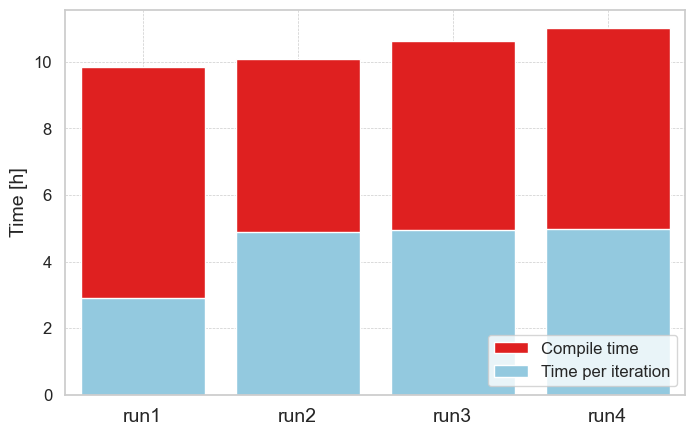

In [9]:
sns.set(style="whitegrid")  # Start with a white grid style

# Save the current Seaborn settings
current_context = sns.plotting_context()
current_style = sns.axes_style()

# Reset to Matplotlib defaults
plt.rcdefaults()

# Reapply the saved Seaborn settings except for the color palette
sns.set_context(current_context)
sns.set_style(current_style)

plt.figure(figsize=(8, 5), dpi=100)

# Create bar plots using Seaborn
sns.barplot(x='run', y='compile_time', data=df, color='red', label='Compile time')
sns.barplot(x='run', y='times_per_it', data=df, color='skyblue', label='Time per iteration')

plt.xlabel(None)
plt.ylabel('Time [h]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Improve the grid, make it lighter
plt.grid(True, linestyle='--', linewidth=0.5)

plt.legend(title=None, fontsize='12', loc='lower right')

# Despine for aesthetics
# sns.despine(trim=False, left=True)

plt.show()


Compare maximum difference between consecutive iterations

In [6]:
# for every pair of consecutive iterations i i+1, I want to calculate the absolute difference between each of the weights, 
# then calculate the sum, the average and standard deviation of these differences and store them in a new dataframe
# then I want to plot the average difference for each iteration
max_diff = {}
keys = list(weights.keys())
keys.sort()
for key in keys:
    new_key = key.split('-')[0]
    max_diff[new_key] = weights[key]['differences_df']

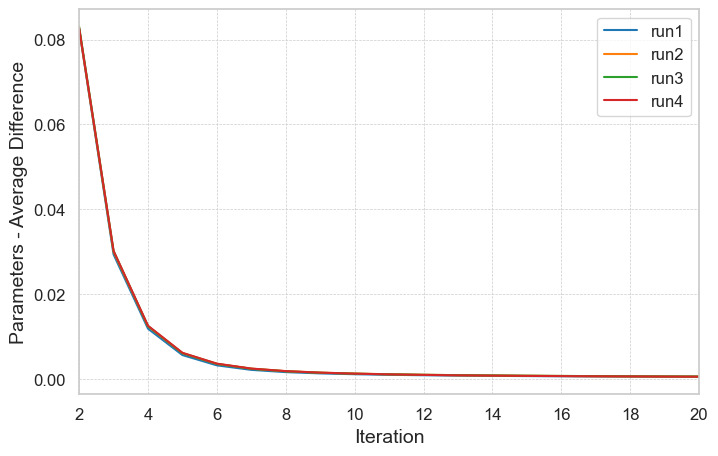

In [11]:
def plot_iteration_weights_seaborn(dataframes, metric='Average Difference', xlim=None, ylim=None, title=None):
    
    sns.set(style="whitegrid")  # Start with a white grid style

    # Save the current Seaborn settings
    current_context = sns.plotting_context()
    current_style = sns.axes_style()

    # Reset to Matplotlib defaults
    plt.rcdefaults()

    # Reapply the saved Seaborn settings except for the color palette
    sns.set_context(current_context)
    sns.set_style(current_style)

    plt.figure(figsize=(8, 5), dpi=100)

    for exp, df in dataframes.items():
        
        # Select rows where iterations and metric values are within the specified limits
        if xlim is not None:
            df = df[(df['Iteration'] >= xlim[0]) & (df['Iteration'] <= xlim[1])]
        if ylim is not None:
            df = df[(df[metric] >= ylim[0]) & (df[metric] <= ylim[1])]

        sns.lineplot(x='Iteration', y=metric, data=df, label=exp, linewidth=1.5)

    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel(f'Parameters - {metric}', fontsize=14)

    # Set axis limits if provided
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # Improve the grid, make it lighter
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Increase the legibility of the ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Set x-axis to display only integer ticks
    plt.xticks(range(2, 21, 2))

    plt.legend(title=None, fontsize='12')

    plt.show()

plot_iteration_weights_seaborn(max_diff, metric='Average Difference', xlim=(2, 20))

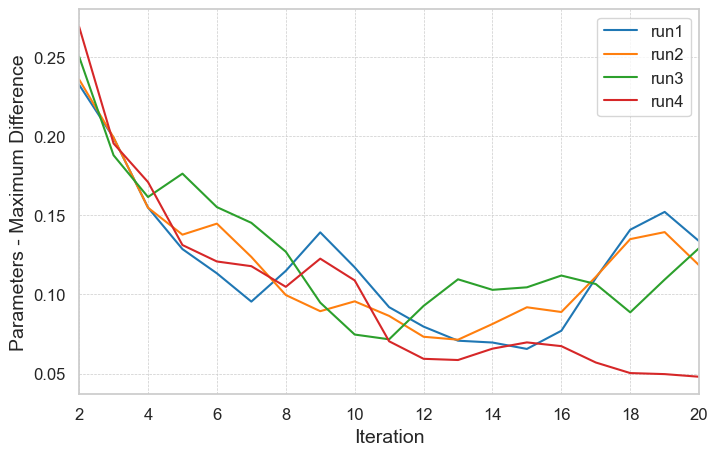

In [12]:
plot_iteration_weights_seaborn(max_diff, metric='Maximum Difference', xlim=(2, 20))

#### Evaluation of learned parameters

In [7]:
experiments = ['run1', 'run2', 'run3', 'run4']
predicates = ['e_activity', 'occ_dec', 'occ_inc', 'p_occupancy']

In [8]:
result_dict = {}
for exp in experiments:
    # Example usage: Replace 'your_file_path.txt' with the actual file path
    file_path = f'models/ebdt_data/p_model/p_model_{exp}_20i.pl'
    result_dict[exp] = lfi.extract_params_from_model_file(file_path)
    #remove duplicates, keep last occurence
    for predicate, data in result_dict[exp].items():
        result_dict[exp][predicate] = lfi.learned_parameters_to_df(predicate, data).reset_index(drop=True)

#### Evaluation of learned activity values

In [9]:
e_ksea_hl60 = pd.read_csv('data/processed/ebdt_data/run1/e_ksea.csv')
e_ksea_mcf7 = pd.read_csv('data/processed/ebdt_data/run3/e_ksea.csv')
e_ksea_ntera2 = pd.read_csv('data/processed/ebdt_data/run4/e_ksea.csv')

In [10]:
e_ksea_hl60['p_base'] = 1 - e_ksea_hl60['p_dec'] - e_ksea_hl60['p_inc']
e_ksea_mcf7['p_base'] = 1 - e_ksea_mcf7['p_dec'] - e_ksea_mcf7['p_inc']
e_ksea_ntera2['p_base'] = 1 - e_ksea_ntera2['p_dec'] - e_ksea_ntera2['p_inc']

e_ksea_hl60.loc[e_ksea_hl60['p_base'] < 0, 'p_base'] = 0
e_ksea_mcf7.loc[e_ksea_mcf7['p_base'] < 0, 'p_base'] = 0
e_ksea_ntera2.loc[e_ksea_ntera2['p_base'] < 0, 'p_base'] = 0

In [11]:
analysis_dicts_hl60 = inf.prep_experiments_for_auc(result_dict, e_ksea_hl60, threshold=0)
analysis_dicts_mcf7 = inf.prep_experiments_for_auc(result_dict, e_ksea_mcf7, threshold=0)
analysis_dicts_ntera2 = inf.prep_experiments_for_auc(result_dict, e_ksea_ntera2, threshold=0)

In [12]:
analysis_dicts_80_hl60 = inf.prep_experiments_for_auc(result_dict, e_ksea_hl60, threshold=0.8)
analysis_dicts_80_mcf7 = inf.prep_experiments_for_auc(result_dict, e_ksea_mcf7, threshold=0.8)
analysis_dicts_80_ntera2 = inf.prep_experiments_for_auc(result_dict, e_ksea_ntera2, threshold=0.8)

AUC Plots

In [19]:
y_onehot_test_list_0 = []
y_score_list_0 = []
experiment_names = []
for exp in analysis_dicts_hl60.keys():
    if exp in ['run1', 'run2']:
        print(exp)
        y_onehot_test_list_0.append(analysis_dicts_hl60[exp]['y_onehot_test'])
        y_score_list_0.append(analysis_dicts_hl60[exp]['y_score'])
        experiment_names.append(exp)
    elif exp == 'run3':
        y_onehot_test_list_0.append(analysis_dicts_mcf7[exp]['y_onehot_test'])
        y_score_list_0.append(analysis_dicts_mcf7[exp]['y_score'])
        experiment_names.append(exp)
    else:
        y_onehot_test_list_0.append(analysis_dicts_ntera2[exp]['y_onehot_test'])
        y_score_list_0.append(analysis_dicts_ntera2[exp]['y_score'])
        experiment_names.append(exp)

run1
run2


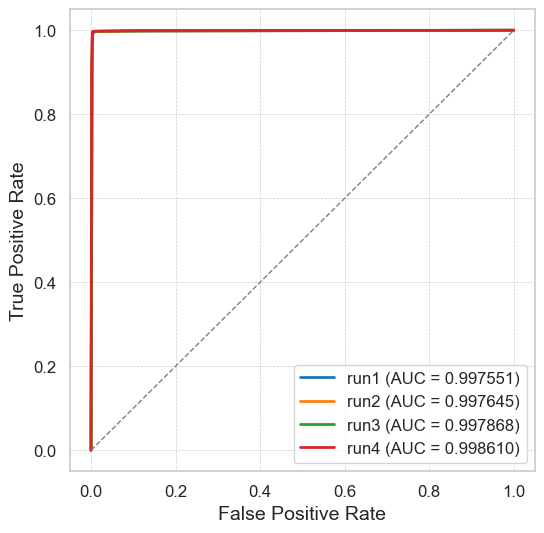

In [20]:
def plot_micro_average_roc_seaborn(y_onehot_tests, y_scores, experiment_names):
    n_experiments = len(experiment_names)

    # Apply Seaborn's default styling
    sns.set_style("whitegrid")

    plt.figure(figsize=(6, 6))

    for i in range(n_experiments):
        fpr, tpr, _ = roc_curve(y_onehot_tests[i].ravel(), y_scores[i].ravel())
        roc_auc = auc(fpr, tpr)

        # Set line style based on experiment number
        linestyle = "--" if i > 9 else "-"  # Dashed line for experiments after exp10

        plt.plot(
            fpr,
            tpr,
            label=f"{experiment_names[i].split('-')[0]} (AUC = {roc_auc:.6f})",
            linestyle=linestyle,
            linewidth=2,
        )

    # Add the reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)

    # Improve the grid, make it lighter
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Increase the legibility of the ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend(loc='lower right', fontsize=12)

    plt.show()

# Usage example
plot_micro_average_roc_seaborn(y_onehot_test_list_0, y_score_list_0, experiment_names)


In [23]:
y_onehot_test_list_80 = []
y_score_list_80 = []
experiment_names = []
for exp in analysis_dicts_hl60.keys():
    if exp in ['run1', 'run2']:
        print(exp)
        y_onehot_test_list_80.append(analysis_dicts_80_hl60[exp]['y_onehot_test'])
        y_score_list_80.append(analysis_dicts_80_hl60[exp]['y_score'])
        experiment_names.append(exp)
    elif exp == 'run3':
        y_onehot_test_list_80.append(analysis_dicts_80_mcf7[exp]['y_onehot_test'])
        y_score_list_80.append(analysis_dicts_80_mcf7[exp]['y_score'])
        experiment_names.append(exp)
    else:
        y_onehot_test_list_80.append(analysis_dicts_80_ntera2[exp]['y_onehot_test'])
        y_score_list_80.append(analysis_dicts_80_ntera2[exp]['y_score'])
        experiment_names.append(exp)

run1
run2


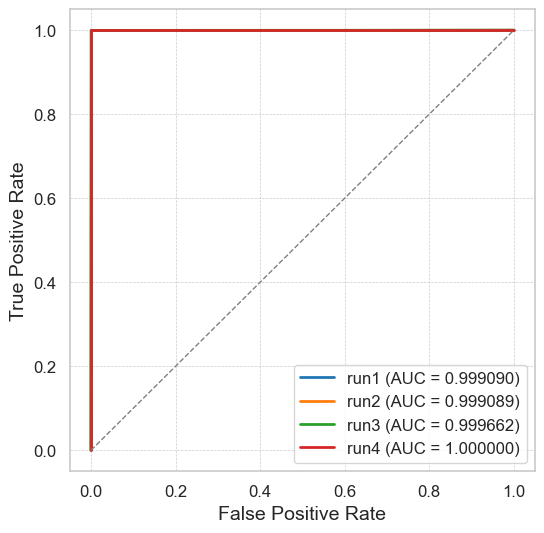

In [24]:
plot_micro_average_roc_seaborn(y_onehot_test_list_80, y_score_list_80, experiment_names)

Density plot

In [18]:
# Extracting data from your analysis dictionary
x = analysis_dicts_hl60['run1']['analysis_dataframe']['prob']
y = analysis_dicts_hl60['run1']['analysis_dataframe']['JSD']
mask_no_match = analysis_dicts_hl60['run1']['analysis_dataframe']['MaxMatch'] == 0
mask_tc_lt_5 = (analysis_dicts_hl60['run1']['analysis_dataframe']['tc'] < 5) & mask_no_match

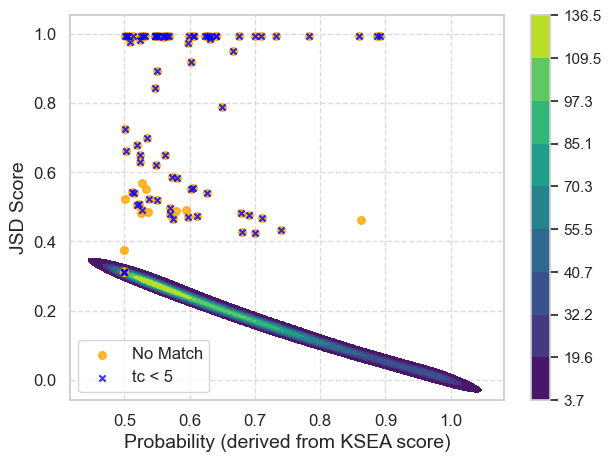

In [63]:
sns.set(style="whitegrid")  # Start with a white grid style

plt.figure(figsize=(7, 5), dpi=100)

# Create the kdeplot
sns.kdeplot(x=x, y=y, cmap='viridis', fill=True, levels=10, cbar=True)

# Scatter plot for 'MaxMatch' == 0 (Non Matches)
plt.scatter(x[mask_no_match], y[mask_no_match], c='orange', s=30, alpha=0.8, label='No Match')

# Scatter plot for 'tc' < 5
plt.scatter(x[mask_tc_lt_5], y[mask_tc_lt_5], c='blue', s=20, alpha=0.8, marker='x', label='tc < 5')

# Increase the legibility of the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding labels, title, and legend
plt.xlabel('Probability (derived from KSEA score)', fontsize=14)
plt.ylabel('JSD Score', fontsize=14)
plt.legend(loc='lower left', fontsize=12)

# Enhance readability
plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()  # Adjusts the plot to ensure everything fits well

# Display the plot
plt.show()


# Tables

In [19]:
mismatch_df = analysis_dicts_hl60['run1']['analysis_dataframe'][mask_no_match]

In [20]:
#es_pmodel = pd.read_csv('data/processed/ebdt_data/sub_network_p/es_interaction.csv')
#mismatch_df = mismatch_df[mismatch_df['enzyme'].isin(es_pmodel['enzyme'])]

In [21]:
mismatch_df

,enzyme,sample,tc,value,prob,p_dec_e_ksea,p_inc_e_ksea,p_base_e_ksea,line,p_dec_e_activity,p_inc_e_activity,p_base_e_activity,JSD,max_category_e_ksea,max_category_e_activity,MaxMatch
0,LRRK2,AZD5363,4.0,inc,0.892471,0.001000,0.892471,0.106529,"p::e_activity(""LRRK2"",""AZD5363"",dec); p::e_act...",1.0,0.000000e+00,0.0,0.994295,p_inc,p_dec,0
1,LRRK2,Ipatasertib,4.0,inc,0.886663,0.001000,0.886663,0.112337,"p::e_activity(""LRRK2"",""Ipatasertib"",dec); p::e...",1.0,0.000000e+00,0.0,0.994295,p_inc,p_dec,0
2,LRRK2,LY2090314,4.0,inc,0.860065,0.001000,0.860065,0.138935,"p::e_activity(""LRRK2"",""LY2090314"",dec); p::e_a...",1.0,0.000000e+00,0.0,0.994295,p_inc,p_dec,0
3,LRRK2,TGX221,4.0,inc,0.783555,0.001000,0.783555,0.215445,"p::e_activity(""LRRK2"",""TGX221"",dec); p::e_acti...",1.0,0.000000e+00,0.0,0.994295,p_inc,p_dec,0
4,PTPRA,GSK2334470,1.0,inc,0.732552,0.001000,0.732552,0.266448,"p::e_activity(""PTPRA"",""GSK2334470"",dec); p::e_...",1.0,0.000000e+00,0.0,0.994295,p_inc,p_dec,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,BRAF,Ripasudil,6.0,dec,0.499325,0.499325,0.001000,0.499675,"p::e_activity(""BRAF"",""Ripasudil"",dec); p::e_ac...",1.0,0.000000e+00,0.0,0.311813,p_base,p_dec,0
335,CDK12,AZD3759,31.0,dec,0.499365,0.499365,0.001000,0.499635,"p::e_activity(""CDK12"",""AZD3759"",dec); p::e_act...",1.0,1.770227e-07,0.0,0.311780,p_base,p_dec,0
336,LATS1,AZD1480,3.0,inc,0.499399,0.001000,0.499399,0.499601,"p::e_activity(""LATS1"",""AZD1480"",dec); p::e_act...",0.0,1.000000e+00,0.0,0.311755,p_base,p_inc,0
337,PTPRG,AZD6738,3.0,inc,0.499450,0.001000,0.499450,0.499550,"p::e_activity(""PTPRG"",""AZD6738"",dec); p::e_act...",0.0,1.000000e+00,0.0,0.311714,p_base,p_inc,0


In [22]:
# sort analysis_dicts_0 by JSD and probability
table1 = mismatch_df.sort_values(by=['JSD', 'prob'], ascending=[False, True]).head(10)
table1 = table1[['enzyme', 'sample', 'tc', 'max_category_e_ksea', 'prob', 'max_category_e_activity', 'JSD']]
table1

,enzyme,sample,tc,max_category_e_ksea,prob,max_category_e_activity,JSD
0,LRRK2,AZD5363,4.0,p_inc,0.892471,p_dec,0.994295
1,LRRK2,Ipatasertib,4.0,p_inc,0.886663,p_dec,0.994295
2,LRRK2,LY2090314,4.0,p_inc,0.860065,p_dec,0.994295
3,LRRK2,TGX221,4.0,p_inc,0.783555,p_dec,0.994295
4,PTPRA,GSK2334470,1.0,p_inc,0.732552,p_dec,0.994295
5,PTPRA,TBCA,1.0,p_dec,0.709264,p_inc,0.994295
6,PTPRA,Ripasudil,1.0,p_dec,0.700615,p_inc,0.994295
7,CLK1,AZD1480,2.0,p_inc,0.675827,p_dec,0.994295
8,LRRK2,CHIR99021,4.0,p_inc,0.640385,p_dec,0.994295
9,LRRK2,AZD6482,4.0,p_inc,0.639794,p_dec,0.994295


In [23]:
table2 = mismatch_df[mismatch_df['JSD'] > 0.98].sort_values(by=['prob'], ascending=[False]).tail(10)
table2 = table2[['enzyme', 'sample', 'tc', 'max_category_e_ksea', 'prob', 'max_category_e_activity', 'JSD']]
table2

,enzyme,sample,tc,max_category_e_ksea,prob,max_category_e_activity,JSD
25,PPM1D,AZD8055,1.0,p_inc,0.546133,p_dec,0.994295
34,CLK1,KN62,2.0,p_inc,0.531822,p_dec,0.993004
26,GRK2,AT13148,4.0,p_inc,0.527633,p_dec,0.994295
27,GRK2,PF3758309,4.0,p_dec,0.524933,p_inc,0.994295
38,STK3,AZD6482,3.0,p_dec,0.524345,p_inc,0.983389
28,LRRK2,Go6976,4.0,p_inc,0.513660,p_dec,0.994295
29,STK3,SP600125,3.0,p_inc,0.505381,p_dec,0.994295
31,STK3,U73122,3.0,p_dec,0.504455,p_inc,0.994279
33,CLK1,SP600125,2.0,p_inc,0.503228,p_dec,0.993235
30,CLK1,Ulixertinib,2.0,p_inc,0.501006,p_dec,0.994295


# Evaluation pf learned interactions

In [28]:
targets_dict = {k: v for k, v in result_dict.items() if 'targets' in v.keys()}
targets_dict.keys()

dict_keys(['run2', 'run3', 'run4'])

In [29]:
t_hl60 = targets_dict['run2']['targets']
t_mcf7 = targets_dict['run3']['targets']
t_ntera2 = targets_dict['run4']['targets']
t_hl60['interaction'] = t_hl60['enzyme'] + '.' + t_hl60['substrate']
t_mcf7['interaction'] = t_mcf7['enzyme'] + '.' + t_mcf7['substrate']
t_ntera2['interaction'] = t_ntera2['enzyme'] + '.' + t_ntera2['substrate']
t_hl60 = t_hl60[['enzyme', 'substrate', 'probability', 'interaction']]
t_mcf7 = t_mcf7[['enzyme', 'substrate', 'probability', 'interaction']]
t_ntera2 = t_ntera2[['enzyme', 'substrate', 'probability', 'interaction']]

In [26]:
t_hl60.to_csv('data/processed/ebdt_data/run2/t_hl60.csv', index=False)
t_mcf7.to_csv('data/processed/ebdt_data/run3/t_mcf7.csv', index=False)
t_ntera2.to_csv('data/processed/ebdt_data/run4/t_ntera2.csv', index=False)

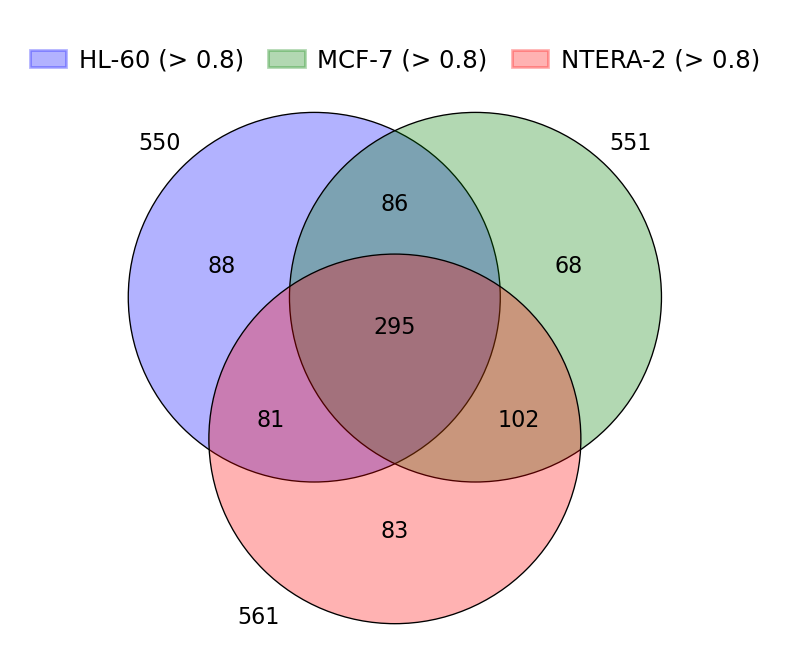

In [31]:
t_hl60_80 = set(t_hl60.loc[t_hl60['probability'] > 0.8, 'interaction'])
t_mcf7_80 = set(t_mcf7.loc[t_mcf7['probability'] > 0.8, 'interaction'])
t_ntera2_80 = set(t_ntera2.loc[t_ntera2['probability'] > 0.8, 'interaction'])

#dict of sets
sets = {
    'HL-60 (> 0.8)': t_hl60_80,
    'MCF-7 (> 0.8)': t_mcf7_80,
    'NTERA-2 (> 0.8)': t_ntera2_80,
    }

venny4py(sets=sets, size=4)

Other plots

In [95]:
cell_line_data = {'HL60': t_hl60, 'MCF7': t_mcf7, 'NTERA2': t_ntera2}

In [96]:
def split_interaction_fill_columns(df):
    # Split the 'interaction' column into 'enzyme' and 'substrate'
    split_data = df['interaction'].str.split('.', expand=True)
    df['enzyme'] = split_data[0]
    df['substrate'] = split_data[1]

    return df

all_interaction_pairs = pd.concat([df['interaction'] for df in cell_line_data.values()])
unique_interaction_pairs = pd.DataFrame(all_interaction_pairs.unique(), columns=['interaction'])
aligned_data = {name: unique_interaction_pairs.merge(df, on='interaction', how='left') for name, df in cell_line_data.items()}
# Apply this function to each cell line dataframe
filled_data = {name: split_interaction_fill_columns(df.copy()) for name, df in cell_line_data.items()}

In [106]:
# Combine the probability data from each cell line
combined_probabilities = pd.DataFrame({
    'interaction': filled_data['HL60']['interaction'],
    'HL60': filled_data['HL60']['probability'],
    'MCF7': filled_data['MCF7']['probability'],
    'NTERA2': filled_data['NTERA2']['probability']
})

# Calculate the variance for each interaction
combined_probabilities['variance'] = combined_probabilities[['HL60', 'MCF7', 'NTERA2']].var(axis=1)

# Select top interactions with highest variance
top_varied_interactions = combined_probabilities.nlargest(50, 'variance')
plot_data = top_varied_interactions[['interaction', 'HL60', 'MCF7', 'NTERA2']]

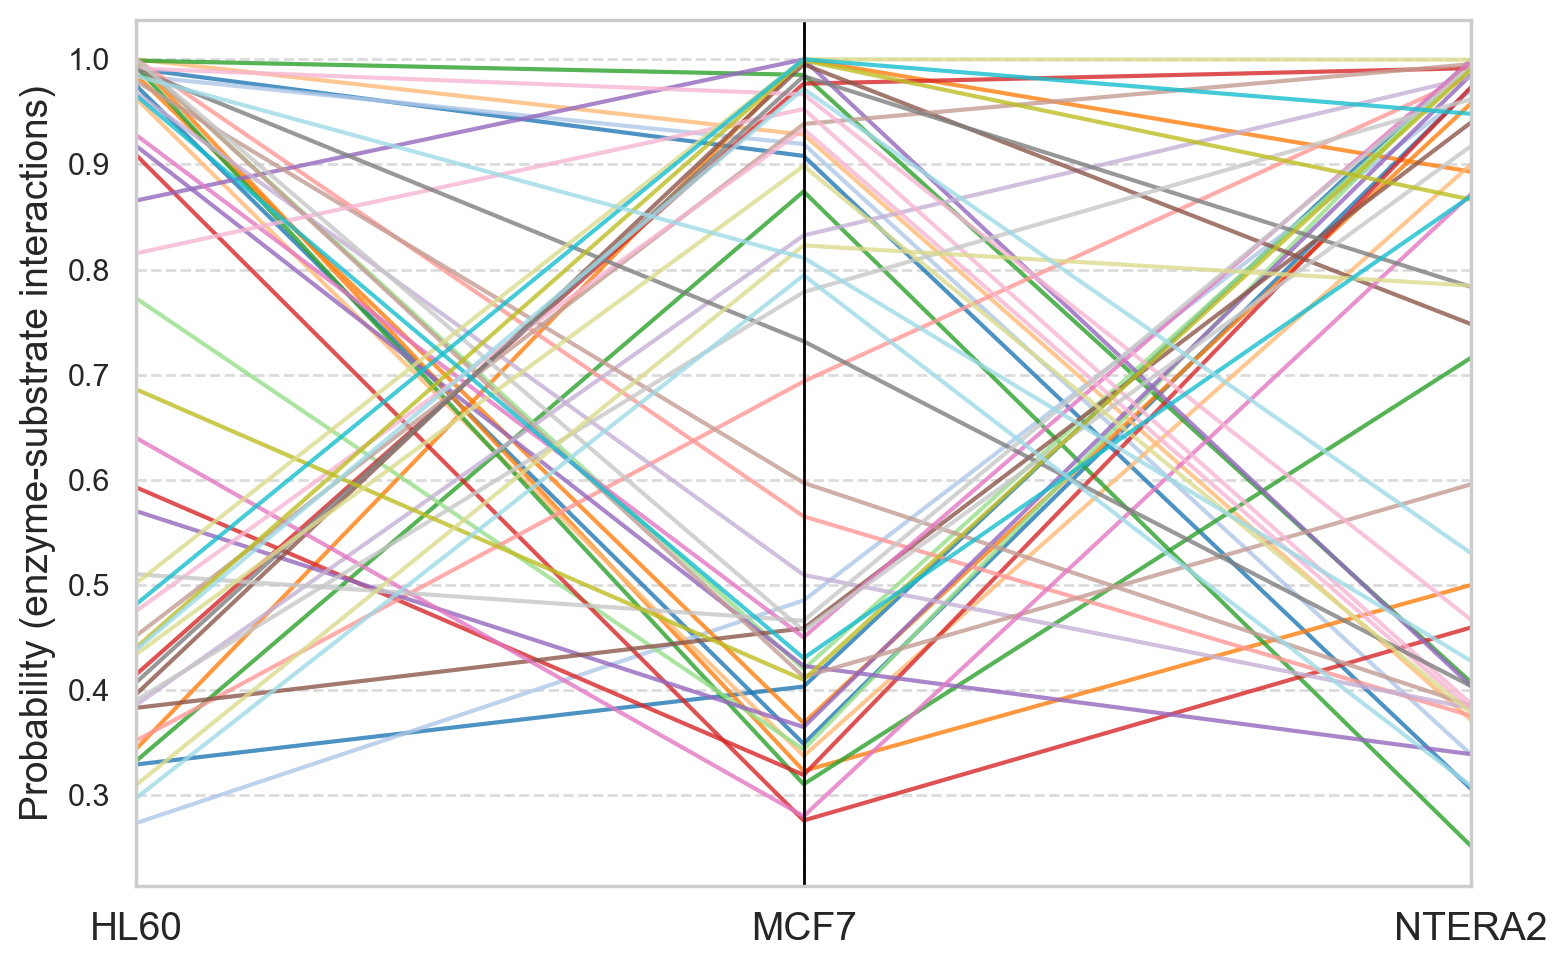

In [98]:
sns.set(style="whitegrid")  # Start with a white grid style
# Create the parallel coordinates plot
plt.figure(figsize=(8, 5))
ax = parallel_coordinates(plot_data, class_column='interaction', colormap=plt.get_cmap("tab20"), alpha=0.8, linewidth=1.5)
plt.ylabel('Probability (enzyme-substrate interactions)', fontsize=14)
plt.xticks(ticks=range(3), labels=['HL60', 'MCF7', 'NTERA2'], fontsize=14)
ax.legend_.remove()  # Explicitly remove the legend
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [104]:
top_varied_interactions = split_interaction_fill_columns(top_varied_interactions)
top_varied_interactions.to_csv('data/processed/ebdt_data/top_varied_interactions.csv', index=False)

# GSEA ?

Ranked list on protein level

In [116]:
ranked_lists = {}
for cell_line, df in filled_data.items():
    substrates = filled_data[cell_line][['substrate', 'probability']]
    substrates['enzyme'] = filled_data[cell_line]['substrate'].apply(lambda x: x.split('(')[0])
    combined_data = pd.concat([filled_data[cell_line][['enzyme', 'probability']], substrates[['enzyme', 'probability']]])
    # drop duplicates, keep values with highest probability
    ranked_lists[cell_line] = combined_data.sort_values('probability', ascending=False).drop_duplicates('enzyme').reset_index(drop=True)

/var/folders/l3/vxqxpwf10_x9jp7g4_x9yy9m0000gn/T/ipykernel_8054/1276319174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  substrates['enzyme'] = filled_data[cell_line]['substrate'].apply(lambda x: x.split('(')[0])
/var/folders/l3/vxqxpwf10_x9jp7g4_x9yy9m0000gn/T/ipykernel_8054/1276319174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  substrates['enzyme'] = filled_data[cell_line]['substrate'].apply(lambda x: x.split('(')[0])
/var/folders/l3/vxqxpwf10_x9jp7g4_x9yy9m0000gn/T/ipykernel_8054/1276319174

In [117]:
ranked_lists['HL60']

,enzyme,probability
0,BCKDHA,1.000000
1,BCKDK,1.000000
2,EEF2K,1.000000
3,EEF2,1.000000
4,MECP2,1.000000
...,...,...
425,PTPRT,0.332542
426,PTPRR,0.330268
427,DUSP26,0.270448
428,DUSP4,0.240715


In [118]:
# save to tab separated file
ranked_lists['HL60'].to_csv('data/processed/ebdt_data/run2/ranked_list_hl60.txt', sep='\t', index=False)
ranked_lists['MCF7'].to_csv('data/processed/ebdt_data/run3/ranked_list_mcf7.txt', sep='\t', index=False)
ranked_lists['NTERA2'].to_csv('data/processed/ebdt_data/run4/ranked_list_ntera2.txt', sep='\t', index=False)

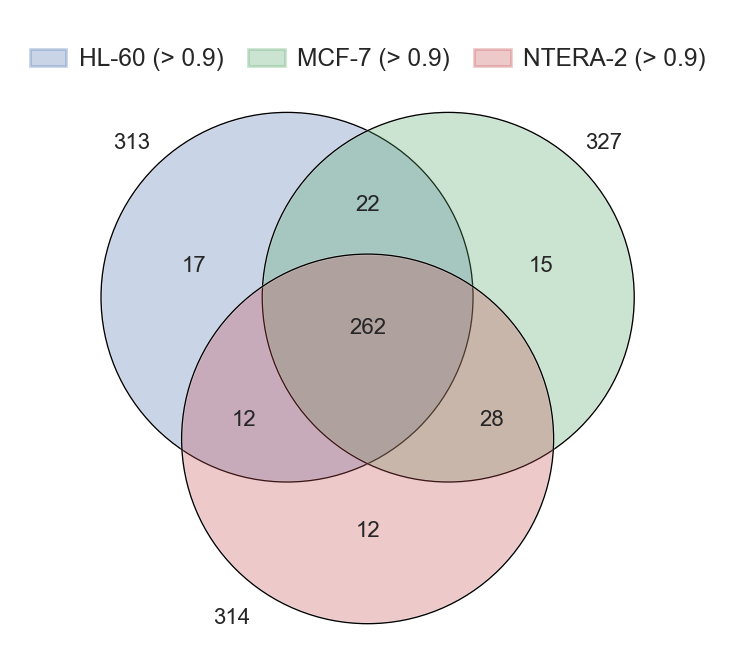

In [111]:
#dict of sets
sets = {
    'HL-60 (> 0.9)': set(ranked_lists['HL60'].loc[ranked_lists['HL60']['probability'] > 0.9, 'enzyme']),
    'MCF-7 (> 0.9)': set(ranked_lists['MCF7'].loc[ranked_lists['MCF7']['probability'] > 0.9, 'enzyme']),
    'NTERA-2 (> 0.9)': set(ranked_lists['NTERA2'].loc[ranked_lists['NTERA2']['probability'] > 0.9, 'enzyme']),
    }

venny4py(sets=sets, size=4)

In [114]:
unique_p_ntera2 = pd.DataFrame(list(sets['NTERA-2 (> 0.9)'] - (sets['HL-60 (> 0.9)'] & sets['MCF-7 (> 0.9)'] & sets['NTERA-2 (> 0.9)'])))